In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
def rollingSum(x, G):
    n = len(x)
    res = np.zeros(n) + np.nan
    currentSum = 0
    for j in range(G):
        currentSum += x[j]
    res[0] = currentSum
    for j in range(1, n-G+1):
        currentSum += x[j+G-1]
        currentSum -= x[j-1]
        res[j] = currentSum
    return(res)

def eta_criterion_help(candidates, mvalues, eta, GLeft, GRight):
    n = len(mvalues)
    res = []
    leftLength = int(eta*GLeft)
    rightLength = int(eta*GRight)
    for j in range(len(candidates)):
        kstar = candidates[j]
        mstar = mvalues[kstar]
        leftthresh = max(1, kstar-leftLength)
        rightthresh = min(n-1, kstar+rightLength)
        largest = True

        for l in range(leftthresh, rightthresh+1):
            if not largest: break
            if mvalues[l] > mstar: largest = False
            
        if largest: 
            res.append(kstar)
    return(res)

In [3]:
def mosum_stat(x, G, GRight = None, varEstMeth = 'mosum', varCustom = None, boundaryExtension = True):
    x = np.array(x)
    n = len(x)
    symmetric = pd.isna(GRight)
    assert not(G < 1 and G > 0.5), 'rel. bandwidth not between 0 and 0.5'
    assert not(G >= n/2), 'bandwidth not smaller than length(x)/2'
    if not symmetric:
        assert not(GRight < 1 and GRight > 0.5), 'rel. bandwidth not between 0 and 0.5'
        assert not(GRight >= n/2), 'bandwidth not smaller than length(x)/2'
        
    
    absBandwidth = (G >=1)
    if not absBandwidth:
        G = int(n*G)
        if not symmetric: GRight = int(n*GRight)
    
    # consistency checks on input
    assert len(x.shape) == 1, 'input vector not one-dimensional'
    assert G > 0 and G < n, 'bandwidth error'

    assert symmetric or (GRight > 0 and GRight < n), 'bandwidth error'
    
    GLeft = G
    if symmetric: GRight = G
    Gmin = min(GRight, GLeft)
    Gmax = max(GRight, GLeft)
    K = Gmin/Gmax
    
    sumsLeft = rollingSum(x, GLeft)
    if(GLeft == GRight):
        sumsRight = sumsLeft
    else:
        sumsRight = rollingSum(x, GRight)
        
    unscaledStatistic = np.concatenate([np.zeros(GLeft-1) + np.nan, Gmin/GRight*sumsRight[(GLeft):n] - Gmin/GLeft*sumsLeft[0:(n-GLeft)], [np.nan]]) / np.sqrt((K+1)*Gmin)
    

    assert not(not pd.isna(varCustom) and varEstMeth != 'custom'), "use varEstMeth = 'custom' when parsing varCustom"
    if varEstMeth == 'custom':
        assert not pd.isna(varCustom), "varCustom must not be Null for varEstMeth = 'custom'"
        assert not len(varCustom) != n, "varCustom is not of length n = length x"
        var = varCustom
    elif varEstMeth == 'global':
        var = np.array([(sum(x**2)-(sum(x)**2)/n)/n] * n)
    else:
        summedSquaresLeft = rollingSum(x**2, GLeft)
        squaredSumsLeft = sumsLeft**2
        varTmpLeft = summedSquaresLeft[0:(n-GLeft +1)] - 1/GLeft*squaredSumsLeft[0:(n-GLeft +1)]
        varLeft = np.concatenate([np.zeros(GLeft -1) + np.nan, varTmpLeft]) / GLeft
        if GLeft == GRight:
            summedSquaresRight = summedSquaresLeft
            squaredSumsRight = squaredSumsLeft
            varTmpRight = varTmpLeft
        else:
            summedSquaresRight = rollingSum(x**2, GRight)
            squaredSumsRight = sumsRight**2
            varTmpRight = summedSquaresRight[0:(n-GRight +1)] - 1/GRight*squaredSumsRight[0:(n-GRight +1)]
        varRight = np.concatenate([varTmpRight[1:(n-GRight+1)], np.zeros(GRight) + np.nan]) / GRight

        if varEstMeth == 'mosum': var = (varLeft + varRight)/2
        elif varEstMeth == 'mosum_left': var = varLeft
        elif varEstMeth == 'mosum_right': var = varRight
        elif varEstMeth == 'mosum_min': var = np.minimum(varLeft, varRight)
        elif varEstMeth == 'mosum_max': var = np.maximum(varRight, varLeft)
        else:
            print("unknown varEstMeth, default to 'mosum'")
            var = (varLeft + varRight)/2
    
    varEstimation = var
    
    if boundaryExtension:
        if n > 2*GLeft:
            weightsLeft = np.sqrt((GLeft + GRight) / np.arange(1, GLeft +1) /  np.arange(GLeft + GRight -1, GRight - 1, -1))
            unscaledStatistic[:GLeft] = np.cumsum(np.mean(x[0:GLeft+GRight]) - x[0:GLeft]) * weightsLeft
            varEstimation[:GLeft] = varEstimation[GLeft-1]
            
        if n > 2*GRight:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide") 
                weightsRight = np.sqrt((GLeft + GRight) / np.arange(GRight-1, -1, -1) / np.arange(GLeft+1, GLeft + GRight + 1))
            xrev = x[(n - GLeft - GRight):n]
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message = "invalid value encountered in multiply")
                unscaledStatistic[(n-GRight):n] = np.cumsum(np.mean(xrev) - xrev)[-len(xrev)+GLeft:] * weightsRight
            unscaledStatistic[n-1] = 0
            varEstimation[(n - GRight):n] = varEstimation[n-GRight-1]
            
    res = abs(unscaledStatistic) / np.sqrt(varEstimation)
    
    retval = {'x':x, 'GLeft':GLeft, 'GRight':GRight, 'varEstMeth':varEstMeth, 'varCustom':varCustom, 'boundaryExtension':boundaryExtension,
              'stat': res, 'rollsums':unscaledStatistic, 'varEstimation':varEstimation}
    
    return(retval)

In [4]:
def asymptoticA(x):
    return(np.sqrt(2*np.log(x)))

def asymptoticB(x, K):
    return(2*np.log(x) + 0.5*np.log(np.log(x)) + np.log((K**2 + K + 1)/(K + 1)) - 0.5*np.log(np.pi))

def mosum_criticalValue(n, GLeft, GRight, alpha):
    Gmin = min(GLeft, GRight)
    Gmax = max(GLeft, GRight)
    K = Gmin/Gmax
    return((asymptoticB(n/Gmin, K) - np.log(np.log(1/np.sqrt(1-alpha)))) / asymptoticA(n/Gmin))

def mosum_pValue(z, n, GLeft, GRight = None):
    GRight = GRight or GLeft
    Gmin = min(GLeft, GRight)
    Gmax = max(GLeft, GRight)
    K = Gmin/Gmax
    return(1 - np.exp(-2*np.exp(asymptoticB(n/Gmin, K) - asymptoticA(n/Gmin)*z)))

In [5]:
def mosum(x, G, GRight = None, varEstMeth = 'mosum', varCustom = None, boundaryExtension = True, threshold = 'critical_value', alpha = 0.2, thresholdCustom = None, 
          criterion = 'eta', eta = 0.3, epsilon = 0.2, doConfint = False, level = 0.05, Nreps = 1000):
        
    GRight = GRight or G
    
    assert alpha >0 and alpha < 1
    assert criterion in ['epsilon', 'eta']
    assert criterion != 'epsilon' or epsilon > 0
    assert criterion != 'eta' or eta > 0
    assert not doConfint or Nreps > 0

    x = np.array(x)
    n = len(x)
    
    m = mosum_stat(x, G, GRight, varEstMeth, varCustom, boundaryExtension)
    GLeft = m['GLeft']
    GRight = m['GRight']
    Gmin = min(GLeft, GRight)
    Gmax = max(GLeft, GRight)
    K = Gmin/Gmax
    changepoints = []
    
    if threshold == 'critical_value' and Gmax/Gmin > 4:
        print('Warning: Bandwidths are too unbalanced, \n (G, GRight) satisfying max(G, GRight)/min(G, GRight) <= 4 is recommended')
    
    if threshold == 'critical_value':
        thresholdVal = mosum_criticalValue(n, GLeft, GRight, alpha)
    elif threshold == 'custom':
        thresholdVal = thresholdCustom
    else:
        print("threshold must be 'critical_value' or 'custom', default to 'critical_value'")
        thresholdVal = mosum_criticalValue(n, GLeft, GRight, alpha)
        
    exceedings = m['stat'] > thresholdVal

    if criterion == 'epsilon':
        exceedingsCount = [1]
        for i in range(1, len(exceedings)):
            if exceedings[i] != exceedings[i-1]:
                exceedingsCount.append(1)
            else: exceedingsCount.append(exceedingsCount[-1] + 1)
        exceedingsCount = exceedings * exceedingsCount
        
        minIntervalSize = max(1, (Gmin + Gmax)/ 2*epsilon)
        intervalEndpoints = [i for i, value in enumerate(np.diff(exceedingsCount) <= -minIntervalSize) if value == True]

        intervalBeginpoints = intervalEndpoints - exceedingsCount[intervalEndpoints] + 1

        if not m['boundaryExtension']:
            
            if exceedings[n-GRight-1] and not ((n-GRight-1) in intervalEndpoints):
                lastBeginpoint = n - GRight - exceedingsCount[n-GRight - 1]
                assert exceedings[np.arange(lastBeginpoint, n - GRight + 1)]
                assert not lastBeginPoint in intervalBeginPoints
                temp = m['stat'][np.arange(lastBeginpoint, n - GRight + 1)]
                highestStatPoint = [i for i, value in enumerate(temp)  if value == max(temp)][0] + lastBeginPoint - 1
                if highestStatPoint-lastBeginpoint >= minIntervalSize/2:
                    np.append(intervalEndpoints, n - GRight)
                    np.append(intervalBeginpoints, lastBeginPoint)
                               
            if exceedings[GLeft-1] and not GLeft in intervalBeginpoints:
                firstEndpoint = [i for i, value in enumerate(np.diff(exceedingsCount)) if value < 0][1]
                assert exceedings[np.arange(GLeft, firstEndpoint)]
                assert not firstEndpoint in intervalEndpoints
                temp = m['stat'][np.arange(GLeft, firstEndpoint + 1)]
                highestStatPoint = [i for i, value in enumerate(temp) if value == max(temp)][0] + GLeft - 1
                if firstEndpoint - highestStatPoint >= minIntervalSize/2:
                    np.append(intervalEndPoints, firstEndpoint)
                    np.append(intervalBeginpoints, GLeft)
        
        assert len(intervalBeginpoints) == len(intervalEndpoints), "something went terribly wrong"
        numChangepoints = len(intervalBeginpoints)
        if numChangepoints > 0:
            for i in range(numChangepoints):
                temp = m['stat'][np.arange(intervalBeginpoints[i], intervalEndpoints[i] + 1)]
                changepoint = intervalBeginpoints[i] + [i for i, value in enumerate(temp) if value == max(temp)][0]
                changepoints.append(changepoint)
                
                
    else: # criterion = 'eta'
        localMaxima = np.append(np.diff(m['stat']) < 0, False) & np.concatenate([[False], np.diff(m['stat']) > 0]) # testing if greater than both neighbours
        
        if not m['boundaryExtension']:
            localMaxima[n-GRight-1] = True
        
        pCandidates = [i for i, value in enumerate(exceedings & localMaxima) if value == True]
        changepoints = eta_criterion_help(pCandidates, m['stat'], eta, GLeft, GRight)
        
        
    retval = {'x':x, 'GLeft':GLeft, 'GRight':GRight, 'varEstMeth': m['varEstMeth'], 'varCustom': m['varCustom'], 'boundaryExtension': m['boundaryExtension'],
              'stat': m['stat'], 'rollsums': m['rollsums'], 'varEstimation': m['varEstimation'], 'threshold': threshold, 'alpha': alpha, 'thresholdCustom':thresholdCustom,
              'thresholdValue': thresholdVal, 'criterion': criterion, 'eta': eta, 'epsilon': epsilon, 'cpts': changepoints}    
    return(retval)    

In [6]:
def plot_mosum(x, G = 0.1, GRight = None, varEstMeth = 'mosum', varCustom = None, boundaryExtension = True, threshold = 'critical_value', alpha = 0.14, thresholdCustom = None, 
          criterion = 'eta', eta = 0.4, epsilon = 0.3, doConfint = False, level = 0.9, Nreps = 1000):
    
    if type(x) != dict:
        N = mosum(x, G, GRight, varEstMeth, varCustom, boundaryExtension, threshold, alpha, thresholdCustom, criterion, eta, epsilon, doConfint, level, Nreps)
    else: N = x
    
    fig, ax = plt.subplots(2, figsize=[10, 8])
    fig.tight_layout(h_pad=4)
    data = N['x']
    ax[0].plot(data)
    
    chps = N['cpts']
    currchp = 0
    if chps == []:
        print('\n \t No changepoints were found.')
    else:
        for chp in chps:
            interv = data[currchp:chp]
            ax[0].axvline(chp, 0.05, 0.95, color = 'red', linestyle = '--')
            ax[0].plot(range(currchp, chp+1), [np.mean(interv)]*(len(interv)+1), c = 'gainsboro', ls = ':')
            currchp = chp
    interv = data[currchp:]
    ax[0].plot(range(currchp, len(data)+1), [np.mean(interv)]*(len(interv)+1), c = 'gainsboro', ls = ':')       
    ax[0].set_xlabel('Timestep',size = 19,labelpad=10)    
    ax[0].legend(('Pollution (mBar)','Change points','moving sum'),loc='upper right', fontsize=14)
    print(chps)
    ax[1].plot(N['stat'], c = 'slategrey')    
    ax[1].axhline(N['thresholdValue'], color = 'cadetblue', linestyle = ':')
    for chp in chps:
        
        ax[1].axvline(chp, 0.05, 0.95, color = 'red', linestyle = '--')
        
    ax[1].axhspan(N['thresholdValue'], max(N['thresholdValue']+0.3, max(N['stat'])+0.2), facecolor='ghostwhite', alpha=0.25)
    ax[1].set_xlabel('Timestep',size = 19,labelpad=10)
    ax[1].legend(('MOSUM statistic', 'critical value for level α','Change points'),loc='upper right', fontsize=14)
    
    plt.show()

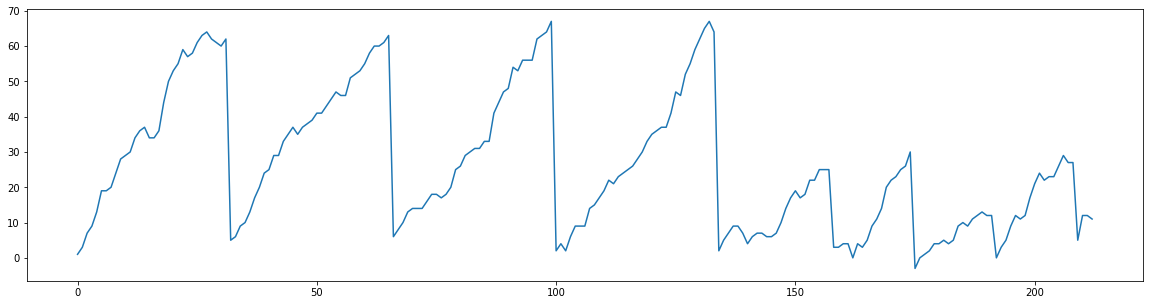

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
df=pd.read_csv('Dataset1.csv', delimiter=',')
plt.plot(df['values'])

[8, 31, 65, 99, 133, 174, 198]


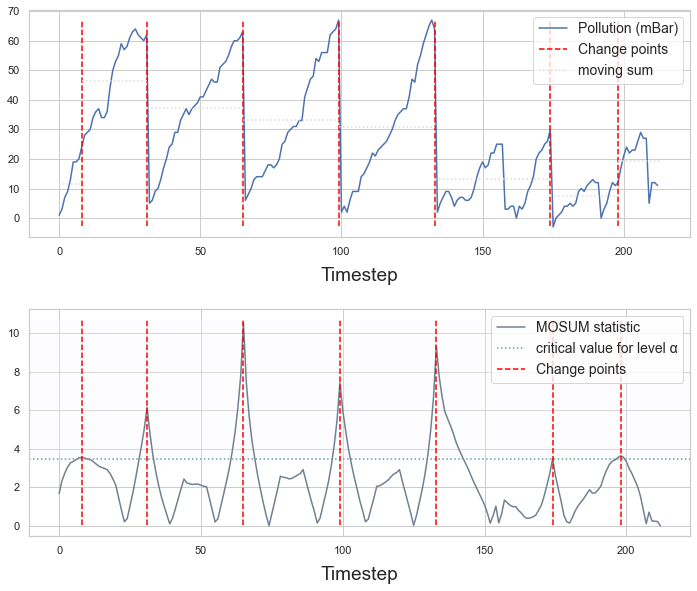

In [28]:
t3 = np.concatenate([[i for i in df['values']]])
from numpy import *
where_are_NaNs = isnan(t3)
t3[where_are_NaNs] = 0
plot_mosum(t3, criterion = 'eta')